### Make environment

In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

import torch

from src.utils.constants import ParamTuple
from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.visualization import plot_environment

height = 7
width = 7
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))

rewards[6,0] = 1
rewards[6,6] = 3

rewards[2,5] = -3
# rewards[5,0] = -1
# rewards[4,0] = -1

rewards = rewards.flatten()


goal_states = np.where(rewards > 0)[0]

wall_states[2,0] = 1
# wall_states[4,1] = 1

wall_states = wall_states.flatten()
wall_states = np.where(wall_states > 0)[0]

agent_p = 0.9
agent_gamma = 0.7
p_true=1

true_params = ParamTuple(agent_p, agent_gamma, rewards)

wall_states = [14]

T_true = transition_matrix(height, width, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

T_torch = torch.tensor(T_True, dtype=torch.float32)
R_torch = torch.tensor(rewards, dtype=torch.float32)
gamma_torch = torch.tensor(agent_gamma, dtype=torch.float32)

### Soft Bellman Operator for fixed point.

In [2]:
def soft_bellman_update_V(R, gamma, T, V):
    return torch.log(torch.sum(torch.exp(torch.matmul(T, R+gamma*V)), axis=1))

def soft_bellman_FP_V(R, gamma, T, V):
    return soft_bellman_update_V(R, gamma, T, V) - V

def soft_V_iteration_torch(R, gamma, T, V_init=None, tol=1e-6):
    if V_init is None:
        V_init = torch.zeros(49)

    V = V_init
    
    while True:
        V_new = soft_bellman_update_V(R, gamma,T, V)
        if torch.max(torch.abs(V - V_new)) < tol:
            break
        V = V_new
    return V

Calculate Derivative of Value Function.

In [3]:
def differentiate_V(R: torch.tensor, gamma: torch.tensor, T: torch.tensor, V: torch.tensor):

    '''
    Calculate the derivative of the value function V with respect to the reward function R and the transition matrix T.

    Args:
    - R (torch.tensor): The reward function R of shape (n_states,)
    - gamma (torch.tensor): The discount factor gamma
    - T (torch.tensor): The transition matrix T of shape (n_states, n_actions, n_states)
    - V (torch.tensor): Initialization of the value function V of shape (n_states,), optional.

    Returns:
    - V_star (torch.tensor): The optimal value function V, shape (n_states,)
    - R_grad_out (torch.tensor): The gradient of the value function V with respect to the reward function R, shape (n_states,) evaluated at V_star
    - T_grad_out (torch.tensor): The gradient of the value function V with respect to the transition matrix T, shape (n_states, n_actions, n_states) evaluated at V_star

    Notes:
    - We replaced the hard max in the Bellman operator with a soft max to make the operator differentiable. Thereby, we no longer converge to the "true" value function
    but rather to an approximation.
    '''

    #Perform value iteration to find a fixed point of the Bellman operator.
    V_star = soft_V_iteration_torch(R, gamma, T, V_init=V, tol=1e-6)

    #Calculate the gradient of the value function using the implicit function theorem.
    # A closed form expression for V is given by psi.
    R_grad = torch.autograd.Variable(R, requires_grad=True)
    T_grad = torch.autograd.Variable(T, requires_grad=True)
    V_star_grad = torch.autograd.Variable(V_star, requires_grad=True)

    df_dtheta = soft_bellman_FP_V(R = R_grad, gamma=gamma, T=T_grad, V = V_star_grad)
    df_dtheta.backward(torch.ones_like(df_dtheta))

    Jacobian = torch.autograd.functional.jacobian(func=soft_bellman_FP_V, inputs=(R_grad, gamma, T_grad, V_star_grad))
    df_dw = Jacobian[3]
    del Jacobian

    #Inverse of Jacobian.
    df_dw_inv = torch.inverse(df_dw)

    R_grad_out = - torch.einsum('ij,j->i', df_dw_inv, R_grad.grad)
    T_grad_out = - torch.einsum('ij,jkl->ikl', df_dw_inv, T_grad.grad)

    return V_star, R_grad_out, T_grad_out

In [4]:
V_star, R_grad_out, T_grad_out = differentiate_V(R = R_torch, gamma = gamma_torch, T = T_torch, V = None)

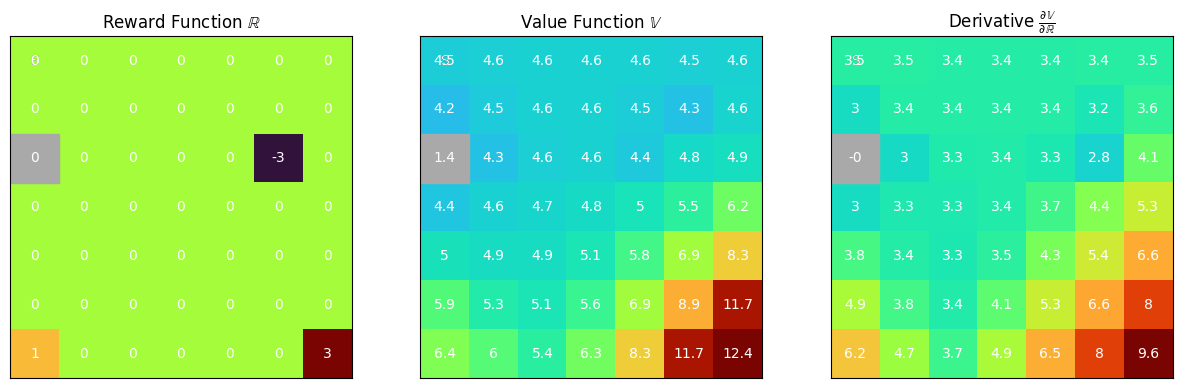

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_environment(reward_function=R_torch.detach().numpy().reshape(height, width), wall_states=wall_states, ax=axs[0], title=r"Reward Function $\mathbb{R}$")
plot_environment(reward_functiofrom src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experimentn=V_star.detach().numpy().reshape(height, width), wall_states=wall_states, ax = axs[1], title=r"Value Function $\mathbb{V}$")
plot_environment(reward_function=R_grad_out.detach().numpy().reshape(height, width), wall_states=wall_states, ax = axs[2], title=r"Derivative $\frac{\partial \mathbb{V}}{\partial \mathbb{R}}$")

## Check Effect on Behavior Map

In [6]:
from src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experiment

custom_world = make_world(height=height,
                          width=width,
                          rewards=rewards,
                          absorbing_states=goal_states,
                          wall_states=wall_states)

/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


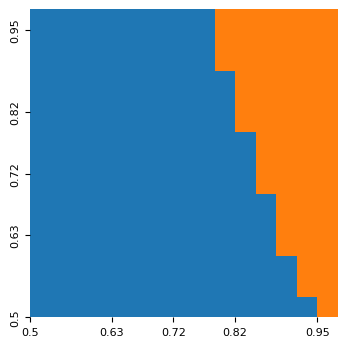

In [9]:
import src.utils.behavior_map as bm

granularity = 15

# Set up parameters to search over
probs = np.linspace(0.5, 0.95, granularity)
gammas = np.linspace(0.5, 0.95, granularity)

out = bm.plot_bmap(
    world=custom_world,
    gammas=gammas,
    probs=probs
)

In [ ]:
def gradient_descent(R, gamma, T, V, learning_rate=0.01, n_iter=100):
    for _ in range(n_iter):
        _, R_grad_out, _ = differentiate_V(R, gamma, T, V)
        R = R - learning_rate * R_grad_out
        V = soft_V_iteration_torch(R, gamma, T, V_init=V, tol=1e-6)
    return R, V